**Authors:** 

- Ravi Teja Kothuru (Primary)
- Soumi Ray
- Anwesha Sarangi

**Title of the Project:** SmartChat: A Context-Aware Conversational Agent

**Description of the Project:** Develop a chatbot that can effectively adapt to context and topic shifts in a conversation, leveraging the Stanford Question Answering Dataset to provide informed and relevant responses, and thereby increasing user satisfaction and engagement.

**Objectives of the Project:** Create a user-friendly web or app interface that enables users to have natural and coherent conversations with the chatbot, with high satisfaction rating.


**Name of the Dataset:** Stanford Question Answering Dataset

**Description of the Dataset:** The Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset consisting of questions posed by crowdworkers on a set of Wikipedia articles. The answer to every question is a segment of text, or span, from the corresponding reading passage. There are 100,000+ question-answer pairs on 500+ articles.
More information can be found at: https://rajpurkar.github.io/SQuAD-explorer/

**Dataset Source:**

Kaggle (https://www.kaggle.com/datasets/stanfordu/stanford-question-answering-dataset)

***Number of Variables in Dataset:*** There are 2 variables in this dataset

- data
- version

Each of these have other variables such as:

- ***context***: A lengthy paragraph that has some information.
- ***question***: A question based on the context.
- ***answer***: An answer to the context from the context.
- ***ans_start***: The index value of context where the answer to the question is started.
- ***ans_end***: The index value of context where the answer to the question is ended.

***Size of the Dataset:*** The dataset has 2 JSON files. One is for training and the other is for validation

- Training Dataset's filename is **train-v1.1.json** and it size is **30.3 MB**.
- Validation Dataset's filename is **dev-v1.1.json** and it size is **4.9 MB**.

# Import all the required libraries

In [36]:
# torch - for PyTorch library for deep learning
# transformers - for loading pre-trained models and tokenizers from Hugging Face
# datasets - for loading datasets, such as SQuAD
# tqdm - for displaying progress bars in loops
# scikit-learn - for various metrics and machine learning tools
# rouge-score - for computing ROUGE score, used in evaluating text generation models
# nltk - Natural Language Toolkit for working with human language data
!pip install torch transformers datasets tqdm scikit-learn rouge-score nltk

# Import the regular expressions module for text processing
import re

# Import pandas for data manipulation and analysis, especially for handling DataFrames
import pandas as pd

# Import PyTorch library
import torch

# Import Dataset and DataLoader classes for creating custom datasets and loading them during training
from torch.utils.data import Dataset, DataLoader

# Import BertTokenizerFast for fast tokenization, and BertForQuestionAnswering for question answering tasks using BERT
from transformers import BertTokenizerFast, BertForQuestionAnswering, get_scheduler

# Import tqdm for showing a progress bar during iterations
from tqdm import tqdm

# Import os for interacting with the operating system, such as file and directory management
import os

# Import precision_score, recall_score, and f1_score for evaluating model performance using precision, recall, and F1 metrics
from sklearn.metrics import f1_score, precision_score, recall_score

# Import rouge_scorer for calculating ROUGE scores, a metric used for evaluating the quality of text generation
from rouge_score import rouge_scorer

# Import sentence_bleu and single_meteor_score from nltk for calculating BLEU and METEOR scores, used in natural language processing evaluation
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score

# Import matplotlib.pyplot for creating plots and visualizations
import matplotlib.pyplot as plt

# Import seaborn for enhanced data visualization, built on top of matplotlib
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Load Dataset and perform basic pre-processing

## Load the SQuAD dataset JSON files

In [2]:
train_data = pd.read_json('train-v1.1.json')
val_data = pd.read_json('dev-v1.1.json')

## Convert the loaded data to a DataFrame

In [3]:
def getDataIntoFrame(squad_data):
    columns = ['context', 'question', 'answer', 'ans_start', 'ans_end']
    dataset = pd.DataFrame(columns=columns)
    i = 0
    for value in squad_data['data']:
        for data in value['paragraphs']:
            for qas in data['qas']:
                answer = qas['answers'][0]['text'] if qas['answers'] else "No answer available."
                answer_start = qas['answers'][0]['answer_start'] if qas['answers'] else -1
                    
                dataset.loc[i] =[data['context'], qas['question'], answer, answer_start, 0]
                i += 1

    return dataset

## Clean Text for both Train and Validation dataframes

As part of cleaning the text, we performed the following steps:

- Converted the complete text to lower case to maintain consistency
- The actually loaded JSON and the converted dataframes have newline `\n` and carriage returns `\r`. Removed them.
- Replaced multiple spaces with single space
- Stripped all the leading and trailing whitespaces

In [4]:
def clean_text(text):
    # Lowercase the text (since we're using an uncased model)
    text = text.lower()
    # Remove newline and carriage returns
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    return text


def cleanData(dataset: pd.DataFrame):
    dataset[['context', 'question', 'answer']] = dataset[['context', 'question', 'answer']].map(clean_text)


train_df = getDataIntoFrame(train_data)
val_df = getDataIntoFrame(val_data)

In [5]:
# Call the cleanData function for both train_df and val_df
cleanData(train_df)
cleanData(val_df)

# Print first 5 rows of the train dataframe
train_df.head()

,context,question,answer,ans_start,ans_end
0,"architecturally, the school has a catholic cha...",to whom did the virgin mary allegedly appear i...,saint bernadette soubirous,515,0
1,"architecturally, the school has a catholic cha...",what is in front of the notre dame main building?,a copper statue of christ,188,0
2,"architecturally, the school has a catholic cha...",the basilica of the sacred heart at notre dame...,the main building,279,0
3,"architecturally, the school has a catholic cha...",what is the grotto at notre dame?,a marian place of prayer and reflection,381,0
4,"architecturally, the school has a catholic cha...",what sits on top of the main building at notre...,a golden statue of the virgin mary,92,0


In [6]:
# Print first 5 rows of the validation dataframe
val_df.head()

,context,question,answer,ans_start,ans_end
0,super bowl 50 was an american football game to...,which nfl team represented the afc at super bo...,denver broncos,177,0
1,super bowl 50 was an american football game to...,which nfl team represented the nfc at super bo...,carolina panthers,249,0
2,super bowl 50 was an american football game to...,where did super bowl 50 take place?,"santa clara, california",403,0
3,super bowl 50 was an american football game to...,which nfl team won super bowl 50?,denver broncos,177,0
4,super bowl 50 was an american football game to...,what color was used to emphasize the 50th anni...,gold,488,0


In [7]:
# Print the number of rows and columns of train dataframe
train_df.shape

(87599, 5)

In [8]:
# Print the number of rows and columns of validation dataframe
val_df.shape

(10570, 5)

## Save Train and Validation dataframes to CSV files

In [9]:
train_df.to_csv("squad_train.csv", index=False)

In [10]:
val_df.to_csv("squad_validation.csv", index=False)

# Create the custom SQuAD dataset from the above cleaned data that is suitable for model training

In [11]:

# Create a custom dataset class for our data
class SQuADataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        context = self.df.iloc[idx]['context']
        question = self.df.iloc[idx]['question']
        answer = self.df.iloc[idx]['answer']
        answer_start = self.df.iloc[idx]['ans_start']

        encoding = self.tokenizer.encode_plus(
            context,
            question,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_offsets_mapping=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        offset_mapping = encoding['offset_mapping'].squeeze().tolist()
        
         # Initialize start and end positions of the answer
        start_position = 0
        end_position = 0

        # Find the token positions corresponding to the answer if it's not unanswerable
        if answer_start != -1:
            for idx, (start, end) in enumerate(offset_mapping):
                if start <= answer_start < end:
                    start_position = idx
                if start < answer_start + len(answer) <= end:
                    end_position = idx
                    break

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'start_positions': torch.tensor(start_position),
            'end_positions': torch.tensor(end_position)
        }


# Set up the tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Create the dataset and data loader
train_dataset = SQuADataset(train_df, tokenizer, max_len=128)
val_dataset = SQuADataset(val_df, tokenizer, max_len=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Convert the created train and validation datasets to Pytorch Tensors

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Decide which architecture to use

## Comparison of the architectures

To develop chatbots, we have different architectures. 
Let us better understand about them before deciding which one to use.

### Differences Between Seq2Seq, Transformers, GPT, GPT-2 (Small, Medium, Large) and BERT (bert-base-uncased)

| Feature            | Seq2Seq                                           | Transformers                                    | GPT                                               | GPT-2 (Small, Medium, Large)                      | BERT (bert-base-uncased)                          |
|--------------------|--------------------------------------------------|------------------------------------------------|--------------------------------------------------|--------------------------------------------------|--------------------------------------------------|
| **Definition**      | A model that transforms an input sequence into an output sequence using an encoder and decoder. | A deep learning architecture using self-attention mechanisms to process input sequences. | A specific Transformer model designed for generating text by predicting the next word in a sequence. | Variants of GPT with different sizes, increasing in the number of layers and parameters (small, medium, large) for more complex text generation tasks. | A bidirectional Transformer-based model designed for understanding the context of words within a sentence. |
| **Usage**          | Tasks where input and output are sequences, like translation and summarization. | A wide range of NLP tasks, including translation and summarization. | Primarily used for text generation tasks like chatbots and text completion. | Text generation, summarization, and creative writing; larger models improve quality and context handling. | Tasks such as sentence classification, named entity recognition, and question answering. |
| **Information**    | Consists of an encoder that processes the input and a decoder that generates the output. | Composed of an encoder and decoder stack, using self-attention to capture relationships between words. | Utilizes only the decoder part of the Transformer, focusing on unidirectional text generation. | Different sizes (small, medium, large) correspond to 124M, 355M, and 774M parameters, respectively; increasing size allows for better handling of complex tasks. | Uses a bidirectional approach to capture context from both left and right; pretrained on large corpora with masked language modeling. |
| **Strengths**      | Effective for varying output lengths; good at capturing context. | Can process sequences in parallel; captures long-range dependencies well. | Excellent at generating coherent and contextually relevant text; adapts to various topics. | Larger models generate higher-quality and more contextually accurate text; effective for nuanced text generation. | Strong at understanding contextual relationships within a sentence; performs well in language understanding tasks. |
| **Limitations**    | Struggles with long sequences due to fixed-length context vectors; may not capture long-range dependencies well. | Requires substantial data and computational power; complexity can make fine-tuning harder. | May generate repetitive or nonsensical outputs; unidirectional nature limits contextual understanding compared to bidirectional models. | Larger models require more computational resources; may still struggle with very long context or nuanced tasks requiring deep understanding. | May not perform as well in text generation compared to GPT-based models; can require significant fine-tuning for specific tasks. |
| **Applications**   | Machine translation, text summarization, conversational agents. | Machine translation, text generation, sentiment analysis. | Chatbots, text completion, creative writing assistance. | Advanced chatbots, long-form text generation, creative writing, and summarization. | Question answering, sentence classification, entity recognition, and text classification. |


## Final Decision of the Architecture to use for training

### Common Interpretations

***Why Multi-turn conversations are not applicable?***
- The SQuaD (satanford Question Answering) Dataset is actually not defined for multi-turn conversations. It is primarily used as a reading comprehension dataset, where there is a `context`, followed by a `question` and an `answer` to it, period. And the next row will have its own `context`, followed by a `question` and an `answer` to it.
- There won't be any reference to previous questions and answers.
- This dataset lacks dialogue-level anootations or context that allows the model to understand how previous Q&As influence the current question.
- Usually in a multi-turn conversational system, a system generally needs to track the state of conversation. But that is not possible here.

***What possibility is applicable?***
- We have tweaked this in such a way that the it can handle variety of topics and it is context-aware.

### Interpretations and Issues observed from GPT2-Medium architecture

For this project, I have initially went with **GPT2-Medium** architecture.

GPT2-Medium is actually very good for the following reasons for the same:

**Text Generation Capability:** GPT has been specifically designed for generating the text, making it highly effective for producing logically reasoned responses in conversational contexts such as to-and-fro chats with chatbot.

**Availability of Pre-trained Models:** Models like GPT-3 are pre-trained on extensive datasets. These kind of models deliver contextually appropriate responses on a wide range of topics without the need for extensive additional training.

**Adaptability and Versatility:** The GPT architecture's exposure to a variety of text sources, allows it to adjust to different conversational styles, thereby imprvoing the user interactions.

**Contextual Awareness:** GPT is very good at maintaining context throughout multiple chat exchanges. It leads to smoother and more continuous dialogues.

**Implementation and Fine-tuning:** Making use of a pre-trained GPT model, we can conserve time and resources, as it demands less data and training compared to Seq2Seq models.

**Performance in Chatbot Applications:** GPT has shown exceptional capability in generating human-like responses.

Considering all these points, we have decided to go with the GPT architecture.

GPT2-Medium has actually predicted very well. But unfortunately, the problem is - there is a small limitation to the developed/trained model.

***The SQuAD dataset whatever we trained using the base GPT2-Medium model works very well in Linux/Ubuntu and Windows machines. But unfortunately, it does not work in MacBooks.***

**Pain points to be noticed:**

- The trained GPT2-Medium model actually predicted more information than the required information. For example: let's says there is a question `Where does the Sun rise?`. The usual answer is `East`. But it predicted as `The Sun rises in the East`.
- We lost the accuracy and the answers that were being predicted, are not as expected as mentioned in the above method.
- Due to the single directional context understanding, GPT2-medium model does not have good understanding of the the text patterns from SQuAD dataset, even though it is trained with millions of parameters.
- We trained data on GPT2-Medium model without passing the `ans_start` and `ans_end` variables to the train set. This could also be one of the reasons. And due to the text generation nature of GPT2-Medium model, we are unable to achieve as expected.
- Due to time and computational resource constraints, we are unable to provide more tweaking and training to the GPT2-Medium model.

For detailed information on the pain points noticed, please visit the **Pain points noticed and the tasks that were not performed** section of [this file](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_gpt2-medium/squad_lora_gpt2_medium_validation.ipynb).

### Final Decision is to choose BERT 'bert-base-uncased' model

We have multiple reasons to have this architecture chosen. Following are the same:

- **Bidirectional Context Comprehension:** BERT is created to grasp a word's context by considering both its left and right surroundings within a sentence. This two-way method enables BERT to effectively grasp word connections and significance, making it ideal for tasks such as answering questions.

- **Prior Knowledge:** The 'bert-base-uncased' model has been pre-trained on a vast amount of text data, giving it a wide range of language comprehension. Improving this model for certain tasks like answering questions with SQuAD v1.1 boosts its effectiveness without the need for starting training all over again.

- BERT has been effective in achieving excellent results in a range of natural language processing tasks, such as question answering, with high accuracy. The structure of the model is ideal for pinpointing answer spans in a provided context, which matches the SQuAD v1.1 dataset's format seamlessly.

- Structured Question Answering Dataset, SQuAD v1.1, includes passages from Wikipedia and questions with answers within the text. It is a common dataset used to assess question answering models and is a popular option for optimizing BERT.

- **Top-notch annotations:** With more than 100,000 question-answer pairs, the dataset offers sufficient training data to optimize BERT and attain superior precision.

- **Direct Adherence to Task Specifications:** Utilizing SQuAD, which is specifically tailored for question answering, guarantees that the fine-tuning procedure is tailored for this task, enabling the BERT model to effectively learn the identification and extraction of answers from provided passages.

- **Efficiency and Suitability:** The structure of BERT aligns well with the structure of the SQuAD dataset, which involves identifying the beginning and ending locations of answers within a given passage. Training BERT on SQuAD v1.1 ensures that the model can utilize its bidirectional capability to comprehend the context and enhance its accuracy.

Below is a table that illustrates why GPT-2 Medium may not be the best option for the SQuAD dataset in comparison to BERT:

| Aspect                                | BERT 'bert-base-uncased'                            | GPT-2 Medium                                       |
|--------------------------------------|----------------------------------------------------|--------------------------------------------------|
| **Architecture**                     | Bidirectional Transformer: Considers both left and right context of a word, making it suitable for tasks like question answering. | Unidirectional Transformer: Predicts the next word based on previous words, making it less suitable for tasks requiring understanding of the entire context. |
| **Context Understanding**            | Bidirectional nature allows it to understand the context of a word by considering surrounding words, leading to better accuracy in finding answer spans. | Only considers previous words, which limits its ability to understand the context of answers within a passage. |
| **Pretraining Objective**            | Trained using Masked Language Modeling (MLM), where some words are masked and the model learns to predict them based on the full context, ideal for tasks like question answering. | Trained using Language Modeling, where the task is to predict the next word, which is more suited for text generation rather than question answering. |
| **Fine-tuning on SQuAD**             | Well-suited for fine-tuning on SQuAD because it can be trained to predict the start and end positions of answers in a passage. | Requires adaptation for question answering, as it is not inherently designed to predict specific answer spans in text. |
| **Performance in Question Answering**| Achieves state-of-the-art results in question answering tasks due to its architecture and pretraining approach. | Tends to perform worse on question answering tasks since its primary design is for text generation, not extracting information from passages. |
| **Suitability for SQuAD Dataset**    | Directly aligns with the SQuAD task of finding specific answer spans in context passages, making it a natural choice for fine-tuning. | Not directly suitable for the task, as it is designed for generating text rather than identifying specific answer locations within a passage. |
| **Inference Speed and Efficiency**   | Efficient for tasks like question answering, where the goal is to extract information from a given passage. | May require more computational resources for similar tasks, as its architecture is optimized for generating longer sequences. |

# Find out the device, load bert-base-uncased model and move it to the corresponding device

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# Model Training and Finetuning

## Explanation of the Training Function

1. **Objective of the Function**: The purpose of this function is to conduct training of a machine learning model by utilizing provided training and evaluation datasets across a designated set of cycles.

2. **Inputs**: The function requires the model for training, along with training data, evaluation data, the specified number of cycles to iterate through, and a learning rate that influences weight adjustments during training.

3. **Loss Monitoring**: A list is created to monitor the loss values calculated throughout training, aiding in assessing the model's learning progress.

4. **Setting up the Optimizer**: A method for optimization is developed to modify the model's parameters according to the determined loss. This contributes to enhancing the model's effectiveness.

5. **Learning Rate Scheduler**: An adjustor is set up to modify the learning rate during the training phase, which may aid in stabilizing the training procedure.

6. **Training Loop**: During each iteration of training,

The model is in training mode, which means it will be trained on the training data.

- An initial value is set for a variable to collect the overall loss during that period.

- A training progress indicator is shown to track the training process.

7. **Batch Processing**: For every set of training data groups:

- The information is transferred to an appropriate computing tool (such as a GPU) to speed up the processing.

- The model makes forecasts using the input data.

- The loss is computed and gathered by measuring the discrepancies between the predictions and the true values.

The loss is included in the list for monitoring reasons.

- The model adjusts its parameters by considering the computed loss in order to enhance upcoming predictions.

- The scheduler determines the adjustment of the learning rate.

8. **Reporting Loss**: The average loss of the last few batches is printed after every 100 batches, providing insight.

9. **Cycle Completion**: At the end of each training cycle, the average loss for that cycle is calculated and displayed.

10. **Validation Phase**: After training, the model is switched to evaluation mode to assess its performance on the evaluation data:
    - The evaluation data is processed similarly, but no adjustments to the model's parameters are made during this phase.
    - The average loss for the evaluation data is calculated and printed, providing a measure of how well the model performs on unseen data.

In [15]:
# Define the training function
def train(model, train_data1, eval_data1, num_epochs=3, lr=3e-5):
    batch_losses = [] 
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # Set up the learning rate scheduler
    num_training_steps = num_epochs * len(train_data1)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):  # Number of epochs
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_data1, desc="Training")
        for batch_idx, batch in enumerate(progress_bar):           
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()
            batch_losses.append(loss.item()) 
            
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

             # Print the average loss for the last 100 batches
            if (batch_idx + 1) % 100 == 0:
                avg_last_100_batches = sum(batch_losses[-100:]) / len(batch_losses[-100:])
                print(f"Average loss of the last 100 batches (batch {batch_idx + 1}): {avg_last_100_batches}")
    
            # Update progress bar with the current loss
            progress_bar.set_postfix({"loss": loss.item()})

        avg_train_loss = total_train_loss / len(train_data1)
        print(f"Average Training Loss for Epoch {epoch + 1}: {avg_train_loss}")


        model.eval()
        total_val_loss = 0
        progress_bar = tqdm(eval_data1, desc="Validation")
        for batch_idx, batch in enumerate(progress_bar):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss = outputs.loss
                total_val_loss += loss.item()
            
        avg_val_loss = total_val_loss / len(eval_data1)
        print(f"Average validation Loss for Epoch {epoch + 1}: {avg_val_loss}")

In [17]:
train(model, train_loader, val_loader)

Training:   4%|▎         | 100/2738 [00:17<07:46,  5.66it/s, loss=0.518]

Average loss of the last 100 batches (batch 100): 0.6423583096265792


Training:   7%|▋         | 200/2738 [00:35<07:31,  5.62it/s, loss=1.15] 

Average loss of the last 100 batches (batch 200): 0.664524872303009


Training:  11%|█         | 300/2738 [00:53<07:14,  5.61it/s, loss=0.612]

Average loss of the last 100 batches (batch 300): 0.6650037533044815


Training:  15%|█▍        | 400/2738 [01:11<06:53,  5.66it/s, loss=1.08] 

Average loss of the last 100 batches (batch 400): 0.6714478057622909


Training:  18%|█▊        | 500/2738 [01:28<06:39,  5.60it/s, loss=0.552]

Average loss of the last 100 batches (batch 500): 0.6601117150485516


Training:  22%|██▏       | 600/2738 [01:46<06:18,  5.65it/s, loss=0.889]

Average loss of the last 100 batches (batch 600): 0.6698948788642883


Training:  26%|██▌       | 700/2738 [02:04<06:01,  5.64it/s, loss=0.538]

Average loss of the last 100 batches (batch 700): 0.6636619964241981


Training:  29%|██▉       | 800/2738 [02:22<05:45,  5.61it/s, loss=1.03] 

Average loss of the last 100 batches (batch 800): 0.6829728370904923


Training:  33%|███▎      | 900/2738 [02:39<05:26,  5.63it/s, loss=0.608]

Average loss of the last 100 batches (batch 900): 0.6725582712888718


Training:  37%|███▋      | 1000/2738 [02:57<05:08,  5.64it/s, loss=0.617]

Average loss of the last 100 batches (batch 1000): 0.6999601230025292


Training:  40%|████      | 1100/2738 [03:15<04:52,  5.61it/s, loss=0.871]

Average loss of the last 100 batches (batch 1100): 0.6931216797232628


Training:  44%|████▍     | 1200/2738 [03:33<04:32,  5.64it/s, loss=0.912]

Average loss of the last 100 batches (batch 1200): 0.6779367724061012


Training:  47%|████▋     | 1300/2738 [03:50<04:15,  5.64it/s, loss=0.512]

Average loss of the last 100 batches (batch 1300): 0.6475279054045677


Training:  51%|█████     | 1400/2738 [04:08<03:57,  5.63it/s, loss=0.474]

Average loss of the last 100 batches (batch 1400): 0.6537387347221375


Training:  55%|█████▍    | 1500/2738 [04:26<03:40,  5.63it/s, loss=0.864]

Average loss of the last 100 batches (batch 1500): 0.6936989489197731


Training:  58%|█████▊    | 1600/2738 [04:44<03:22,  5.62it/s, loss=0.38] 

Average loss of the last 100 batches (batch 1600): 0.62197854667902


Training:  62%|██████▏   | 1700/2738 [05:01<03:04,  5.63it/s, loss=0.741]

Average loss of the last 100 batches (batch 1700): 0.6622211998701095


Training:  66%|██████▌   | 1800/2738 [05:19<02:46,  5.64it/s, loss=0.872]

Average loss of the last 100 batches (batch 1800): 0.6505691888928413


Training:  69%|██████▉   | 1900/2738 [05:37<02:28,  5.64it/s, loss=0.633]

Average loss of the last 100 batches (batch 1900): 0.6834261089563369


Training:  73%|███████▎  | 2000/2738 [05:55<02:11,  5.62it/s, loss=0.614]

Average loss of the last 100 batches (batch 2000): 0.6650167736411094


Training:  77%|███████▋  | 2100/2738 [06:13<01:53,  5.60it/s, loss=0.75] 

Average loss of the last 100 batches (batch 2100): 0.6869347703456878


Training:  80%|████████  | 2200/2738 [06:30<01:36,  5.60it/s, loss=0.474]

Average loss of the last 100 batches (batch 2200): 0.7069280380010605


Training:  84%|████████▍ | 2300/2738 [06:48<01:17,  5.65it/s, loss=0.893]

Average loss of the last 100 batches (batch 2300): 0.6694514822959899


Training:  88%|████████▊ | 2400/2738 [07:06<01:00,  5.63it/s, loss=0.804]

Average loss of the last 100 batches (batch 2400): 0.656953042447567


Training:  91%|█████████▏| 2500/2738 [07:24<00:42,  5.59it/s, loss=0.683]

Average loss of the last 100 batches (batch 2500): 0.6688474968075753


Training:  95%|█████████▍| 2600/2738 [07:41<00:24,  5.64it/s, loss=0.838]

Average loss of the last 100 batches (batch 2600): 0.6809370693564415


Training:  99%|█████████▊| 2700/2738 [07:59<00:06,  5.60it/s, loss=0.494]

Average loss of the last 100 batches (batch 2700): 0.6972499281167984


Training: 100%|██████████| 2738/2738 [08:06<00:00,  5.63it/s, loss=0.335]


Average Training Loss for Epoch 1: 0.6698534366388318


Validation: 100%|██████████| 331/331 [00:24<00:00, 13.30it/s]


Average validation Loss for Epoch 1: 0.9814940393421225


Training:   4%|▎         | 100/2738 [00:17<07:48,  5.63it/s, loss=0.406]

Average loss of the last 100 batches (batch 100): 0.42323727905750275


Training:   7%|▋         | 200/2738 [00:35<07:31,  5.62it/s, loss=0.442]

Average loss of the last 100 batches (batch 200): 0.4259940832853317


Training:  11%|█         | 300/2738 [00:53<07:10,  5.66it/s, loss=0.414]

Average loss of the last 100 batches (batch 300): 0.4279849003255367


Training:  15%|█▍        | 400/2738 [01:11<06:54,  5.65it/s, loss=0.455]

Average loss of the last 100 batches (batch 400): 0.40804175853729246


Training:  18%|█▊        | 500/2738 [01:28<06:36,  5.65it/s, loss=0.267]

Average loss of the last 100 batches (batch 500): 0.4254739524424076


Training:  22%|██▏       | 600/2738 [01:46<06:19,  5.63it/s, loss=0.339]

Average loss of the last 100 batches (batch 600): 0.4404203554987907


Training:  26%|██▌       | 700/2738 [02:04<06:03,  5.61it/s, loss=0.217]

Average loss of the last 100 batches (batch 700): 0.4349155117571354


Training:  29%|██▉       | 800/2738 [02:22<05:45,  5.61it/s, loss=0.485]

Average loss of the last 100 batches (batch 800): 0.41740657687187194


Training:  33%|███▎      | 900/2738 [02:39<05:27,  5.62it/s, loss=0.566]

Average loss of the last 100 batches (batch 900): 0.4796251252293587


Training:  37%|███▋      | 1000/2738 [02:57<05:09,  5.62it/s, loss=0.361]

Average loss of the last 100 batches (batch 1000): 0.45344379663467405


Training:  40%|████      | 1100/2738 [03:15<04:53,  5.57it/s, loss=0.6]  

Average loss of the last 100 batches (batch 1100): 0.43852598652243613


Training:  44%|████▍     | 1200/2738 [03:33<04:34,  5.61it/s, loss=0.299]

Average loss of the last 100 batches (batch 1200): 0.4431722529232502


Training:  47%|████▋     | 1300/2738 [03:50<04:15,  5.63it/s, loss=0.559]

Average loss of the last 100 batches (batch 1300): 0.4438588830828667


Training:  51%|█████     | 1400/2738 [04:08<03:57,  5.64it/s, loss=0.288]

Average loss of the last 100 batches (batch 1400): 0.4113195690512657


Training:  55%|█████▍    | 1500/2738 [04:26<03:39,  5.64it/s, loss=0.614]

Average loss of the last 100 batches (batch 1500): 0.43174351155757906


Training:  58%|█████▊    | 1600/2738 [04:44<03:21,  5.65it/s, loss=0.315]

Average loss of the last 100 batches (batch 1600): 0.4160684312880039


Training:  62%|██████▏   | 1700/2738 [05:01<03:04,  5.63it/s, loss=0.309]

Average loss of the last 100 batches (batch 1700): 0.4271538206934929


Training:  66%|██████▌   | 1800/2738 [05:19<02:46,  5.63it/s, loss=0.452]

Average loss of the last 100 batches (batch 1800): 0.4083107154071331


Training:  69%|██████▉   | 1900/2738 [05:37<02:28,  5.65it/s, loss=0.367]

Average loss of the last 100 batches (batch 1900): 0.423989337682724


Training:  73%|███████▎  | 2000/2738 [05:55<02:10,  5.63it/s, loss=0.378]

Average loss of the last 100 batches (batch 2000): 0.4274235332012177


Training:  77%|███████▋  | 2100/2738 [06:12<01:53,  5.64it/s, loss=0.331]

Average loss of the last 100 batches (batch 2100): 0.4405277831852436


Training:  80%|████████  | 2200/2738 [06:30<01:35,  5.63it/s, loss=0.47] 

Average loss of the last 100 batches (batch 2200): 0.3970172184705734


Training:  84%|████████▍ | 2300/2738 [06:48<01:17,  5.64it/s, loss=0.315]

Average loss of the last 100 batches (batch 2300): 0.4529651851952076


Training:  88%|████████▊ | 2400/2738 [07:06<01:00,  5.63it/s, loss=0.566]

Average loss of the last 100 batches (batch 2400): 0.4542316357791424


Training:  91%|█████████▏| 2500/2738 [07:23<00:42,  5.66it/s, loss=0.353]

Average loss of the last 100 batches (batch 2500): 0.44322420239448546


Training:  95%|█████████▍| 2600/2738 [07:41<00:24,  5.63it/s, loss=0.408]

Average loss of the last 100 batches (batch 2600): 0.44647241026163104


Training:  99%|█████████▊| 2700/2738 [07:59<00:06,  5.60it/s, loss=0.483]

Average loss of the last 100 batches (batch 2700): 0.41951008543372154


Training: 100%|██████████| 2738/2738 [08:06<00:00,  5.63it/s, loss=0.259]


Average Training Loss for Epoch 2: 0.43159852172550794


Validation: 100%|██████████| 331/331 [00:24<00:00, 13.31it/s]


Average validation Loss for Epoch 2: 1.0810882857468913


Training:   4%|▎         | 100/2738 [00:17<07:47,  5.65it/s, loss=0.271]

Average loss of the last 100 batches (batch 100): 0.28261320061981676


Training:   7%|▋         | 200/2738 [00:35<07:27,  5.67it/s, loss=0.288]

Average loss of the last 100 batches (batch 200): 0.29564214386045934


Training:  11%|█         | 300/2738 [00:53<07:13,  5.62it/s, loss=0.539]

Average loss of the last 100 batches (batch 300): 0.3043637930601835


Training:  15%|█▍        | 400/2738 [01:10<06:57,  5.59it/s, loss=0.319]

Average loss of the last 100 batches (batch 400): 0.2946875374019146


Training:  18%|█▊        | 500/2738 [01:28<06:37,  5.62it/s, loss=0.248]

Average loss of the last 100 batches (batch 500): 0.2886260879039764


Training:  22%|██▏       | 600/2738 [01:46<06:18,  5.65it/s, loss=0.307] 

Average loss of the last 100 batches (batch 600): 0.2724345351010561


Training:  26%|██▌       | 700/2738 [02:04<06:01,  5.63it/s, loss=0.368] 

Average loss of the last 100 batches (batch 700): 0.28938561253249645


Training:  29%|██▉       | 800/2738 [02:21<05:42,  5.66it/s, loss=0.353] 

Average loss of the last 100 batches (batch 800): 0.2682596127688885


Training:  33%|███▎      | 900/2738 [02:39<05:26,  5.63it/s, loss=0.306] 

Average loss of the last 100 batches (batch 900): 0.2903344576060772


Training:  37%|███▋      | 1000/2738 [02:57<05:07,  5.66it/s, loss=0.275]

Average loss of the last 100 batches (batch 1000): 0.29707550674676897


Training:  40%|████      | 1100/2738 [03:15<04:50,  5.64it/s, loss=0.139] 

Average loss of the last 100 batches (batch 1100): 0.2798809629678726


Training:  44%|████▍     | 1200/2738 [03:33<04:32,  5.64it/s, loss=0.187]

Average loss of the last 100 batches (batch 1200): 0.2913319482654333


Training:  47%|████▋     | 1300/2738 [03:50<04:14,  5.65it/s, loss=0.343]

Average loss of the last 100 batches (batch 1300): 0.29525055445730686


Training:  51%|█████     | 1400/2738 [04:08<03:58,  5.62it/s, loss=0.316]

Average loss of the last 100 batches (batch 1400): 0.2766328880190849


Training:  55%|█████▍    | 1500/2738 [04:26<03:40,  5.61it/s, loss=0.598]

Average loss of the last 100 batches (batch 1500): 0.2805609745532274


Training:  58%|█████▊    | 1600/2738 [04:44<03:22,  5.63it/s, loss=0.195]

Average loss of the last 100 batches (batch 1600): 0.2938973419368267


Training:  62%|██████▏   | 1700/2738 [05:01<03:04,  5.61it/s, loss=0.388]

Average loss of the last 100 batches (batch 1700): 0.3067274210602045


Training:  66%|██████▌   | 1800/2738 [05:19<02:46,  5.62it/s, loss=0.25]  

Average loss of the last 100 batches (batch 1800): 0.27714520283043387


Training:  69%|██████▉   | 1900/2738 [05:37<02:29,  5.62it/s, loss=0.205] 

Average loss of the last 100 batches (batch 1900): 0.2854195995628834


Training:  73%|███████▎  | 2000/2738 [05:55<02:11,  5.61it/s, loss=0.284] 

Average loss of the last 100 batches (batch 2000): 0.2771904042363167


Training:  77%|███████▋  | 2100/2738 [06:12<01:52,  5.66it/s, loss=0.278]

Average loss of the last 100 batches (batch 2100): 0.3015096965432167


Training:  80%|████████  | 2200/2738 [06:30<01:35,  5.63it/s, loss=0.263] 

Average loss of the last 100 batches (batch 2200): 0.26939683929085734


Training:  84%|████████▍ | 2300/2738 [06:48<01:17,  5.62it/s, loss=0.231] 

Average loss of the last 100 batches (batch 2300): 0.2869211138039827


Training:  88%|████████▊ | 2400/2738 [07:06<00:59,  5.65it/s, loss=0.183] 

Average loss of the last 100 batches (batch 2400): 0.29031938686966896


Training:  91%|█████████▏| 2500/2738 [07:24<00:42,  5.65it/s, loss=0.127] 

Average loss of the last 100 batches (batch 2500): 0.296635095179081


Training:  95%|█████████▍| 2600/2738 [07:42<00:24,  5.60it/s, loss=0.189] 

Average loss of the last 100 batches (batch 2600): 0.3149970731139183


Training:  99%|█████████▊| 2700/2738 [07:59<00:06,  5.62it/s, loss=0.219]

Average loss of the last 100 batches (batch 2700): 0.2911440251767635


Training: 100%|██████████| 2738/2738 [08:06<00:00,  5.63it/s, loss=0.25]  


Average Training Loss for Epoch 3: 0.2889414794030113


Validation: 100%|██████████| 331/331 [00:24<00:00, 13.31it/s]

Average validation Loss for Epoch 3: 1.2183502224186755


# Save Model, Tokenizer etc.

In [18]:
# Define the directory where you want to save the model
model_save_path = 'squad-bert-trained/saved_model'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


# Save the trained model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('squad-bert-trained/saved_model/tokenizer_config.json',
 'squad-bert-trained/saved_model/special_tokens_map.json',
 'squad-bert-trained/saved_model/vocab.txt',
 'squad-bert-trained/saved_model/added_tokens.json',
 'squad-bert-trained/saved_model/tokenizer.json')

# Load the saved model and tokenizer for Validation

In [19]:
# Load the saved model and tokenizer
model_save_path = 'squad-bert-trained/saved_model'
model = BertForQuestionAnswering.from_pretrained(model_save_path)
tokenizer = BertTokenizerFast.from_pretrained(model_save_path)

print(f"Moving the model to {device}\n\n")
model.to(device)

# Set the model to evaluation mode
model.eval()

Moving the model to cuda




BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# Define the core logic for validation

## Description of how the Answer Generation Function works

1. **Function Objective**: The aim of this function is to determine a response to a particular question using the given information. It breaks down the context into smaller segments to ensure efficient management.

2. **Description of Parameters**: The function requires two inputs: the question posed and the context with pertinent information.

3. **Restriction on Context Size**: A limit is placed on the size of the context to prevent it from surpassing the model's input processing capacity.

4. **Context Chunking**: The context is segmented into smaller segments (or chunks) that have a maximum specified size. This enables effective processing without burdening the model.

5. **Collection of Answers**: A blank list is created in order to save possible answers taken from each section of the context.

6. **Loop for Chunk Processing**: Perform actions for every chunk of context.

The model requires the chunk and question to be converted to a suitable format. This involves transforming them into a numerical format while making sure they stay within the maximum context size.

7. **Generating Predictions**: The model analyzes the tokenized input to produce predictions on the location of the answer's start and end in the context.

- The forecasts for the start and conclusion of the answer span are acquired.

8. **Locating Answer Tokens**: The function searches for the tokens that have the highest predicted scores for the start and end positions of the answer.

9. **Information Retrieval**: The tokens that have been recognized are transformed into a legible string format in order to create the answer. This includes gathering the tokens predicted to start and end, then combining them to form a coherent response.

10. **Merging Responses**: Once all chunks have been processed, the answers obtained from each chunk are merged together to form a unified response.

11. **Last Step of Formatting**: We eliminate any extra markers, such as a classification token.

In [27]:
def answer_question(question, context):
    max_context_size = 512
    chunk_size = max_context_size

    chunks = [context[i:i+chunk_size] for i in range(0, len(context), chunk_size)]

    answers = []
    for chunk in chunks:
        # Tokenize the chunk
        inputs = tokenizer(chunk, question, return_tensors='pt', truncation=True, max_length=max_context_size).to(device)

        # Generate the output
        with torch.no_grad():
            outputs = model(**inputs)

            # Get most likely beginning and end of the answer span
            answer_start_scores = outputs.start_logits
            answer_end_scores = outputs.end_logits
    
            # Find the tokens with the highest `start` and `end` scores
            answer_start = torch.argmax(answer_start_scores)
            answer_end = torch.argmax(answer_end_scores) + 1
    
            # Convert the tokens to text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    
            answers.append(answer)
    
    # Combine the answers from each chunk
    answer = ' '.join(answers)
    answer = answer.replace('[CLS]', '')
    return answer.strip()

## Validate one context from the validation dataset

In [28]:
context = """Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.
The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10
to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."""

question = "Who won Super Bowl 50?"

# Call the answer_question method to get the answer
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Who won Super Bowl 50?
Answer: denver broncos


## Testing new contexts from internet

### Testing Context-1 from Internet

In [29]:
context = """
The Indian Space Research Organisation (ISRO) is the primary space agency of the Government of India. 
Established in 1969, ISRO is responsible for the country's space program, which includes satellite development, 
launch vehicles, space exploration, and human spaceflight. ISRO has achieved numerous milestones, 
including launching satellites for communication, navigation, and weather forecasting, 
as well as sending spacecraft to the Moon and Mars. ISRO's mission is to harness space technology for national development, 
while also pursuing scientific research and exploration.
"""

question = "What are the milestones of ISRO?"

# Get the answer from the model
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What are the milestones of ISRO?
Answer: launching satellites for communication, navigation, and weather forecasting scientific research and exploration


### Testing Context-2 from Internet

In [30]:
# Test with a new question and context
context = """
Music is an art form whose medium is sound and silence. It is a universal language that 
can evoke emotions, convey messages, and bring people together. Music has been an 
integral part of human culture for centuries, with various genres and styles emerging 
across the world. From classical to contemporary, music has the power to inspire, heal, 
and entertain.
"""
question = "What is the difference between Music and Harmony?"

# Get the answer from the model
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What is the difference between Music and Harmony?
Answer: heal, and entertain


### Testing Context-3 from Internet

In [33]:
context = """
Space robotics is a field of robotics that focuses on the design, development, and operation of robots that can 
survive and function in the harsh environment of space. These robots are designed to perform a variety of tasks, 
such as space exploration, satellite maintenance, and planetary surface operations. 
Space robots can be autonomous or remotely controlled, and they often require specialized 
systems to withstand the extreme temperatures, radiation, and vacuum of space.

Space robotics has many applications, including:

Planetary exploration: Robots like NASA's Curiosity Rover and Perseverance Rover 
have been used to explore the surface of Mars and gather data about the planet's geology and climate.
Satellite maintenance: Robots like the Canadarm2 robotic arm on the 
International Space Station have been used to perform maintenance tasks and repairs on satellites in orbit.
Asteroid mining: Robots are being developed to explore and mine asteroids 
for valuable resources like water and precious metals.
"""

question = "What are the applications of Space Robotics?"

# Get the answer from the model
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What are the applications of Space Robotics?
Answer: space exploration, satellite maintenance, and planetary surface operations gather data about the planet ' s geology and climate


# Calculation of Performance Metrics

We have calculated the following Performance Metrics as part of this project

- **ROUGE score:** This measures the overlap between the predicted answer and the ground truth answer, but it's more focused on the longest common subsequence.
- **BLEU score:** This measures the similarity between the predicted answer and the ground truth answer, but it's more focused on the fluency and coherence of the answer.

## Evaluation Metrics for Natural Language Processing Tasks

### Overview of Common Metrics

Note that these are commonly used metrics to evaluate the performance of NLP models:

* **ROUGE score**: This requires a library like `rouge-score`.

* **BLEU score**: This requires a library like `nltk`.

In [37]:
import warnings
warnings.filterwarnings("ignore")

# Initialize the metrics
rouge1 = 0
rouge2 = 0
rougel = 0
bleu = 0

# Initialize lists to store answers and predicted answers
answers = []
predicted_answers = []

# Iterate over the predictions
for question_id in range(val_df.shape[0]):
    # Get the predicted answer
    predicted_answer = answer_question(val_df.iloc[question_id]['question'], val_df.iloc[question_id]['context']).lower().strip()
    answer = (val_df.iloc[question_id]['answer']).lower().strip()

    # Store the answers and predicted answers
    answers.append(answer)
    predicted_answers.append(predicted_answer)

    # Calculate the metrics
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    rouge_scores = scorer.score(answer, predicted_answer)
    rouge1 += rouge_scores['rouge1'].fmeasure
    rouge2 += rouge_scores['rouge2'].fmeasure
    rougel += rouge_scores['rougeL'].fmeasure
    bleu += sentence_bleu([answer.split()], predicted_answer.split(), weights=(1.0, 0.0, 0.0, 0.0))

# Calculate the average metrics
em /= len(val_df)
f1 /= len(val_df)
rouge1 /= len(val_df)
rouge2 /= len(val_df)
rougel /= len(val_df)
bleu /= len(val_df)

# Print the metrics
print('ROUGE-1:', rouge1)
print('ROUGE-2:', rouge2)
print('ROUGE-L:', rougel)
print('BLEU:', bleu)

ROUGE-1: 0.6158480145518543
ROUGE-2: 0.3714845707944188
ROUGE-L: 0.6141959355809109
BLEU: 0.47322026612191537


# Data Visualization of this approach

## Plot-1: Answers vs Predicted Answers

This plot depicts that all the 10570 answers from the validation dataset are predicted.

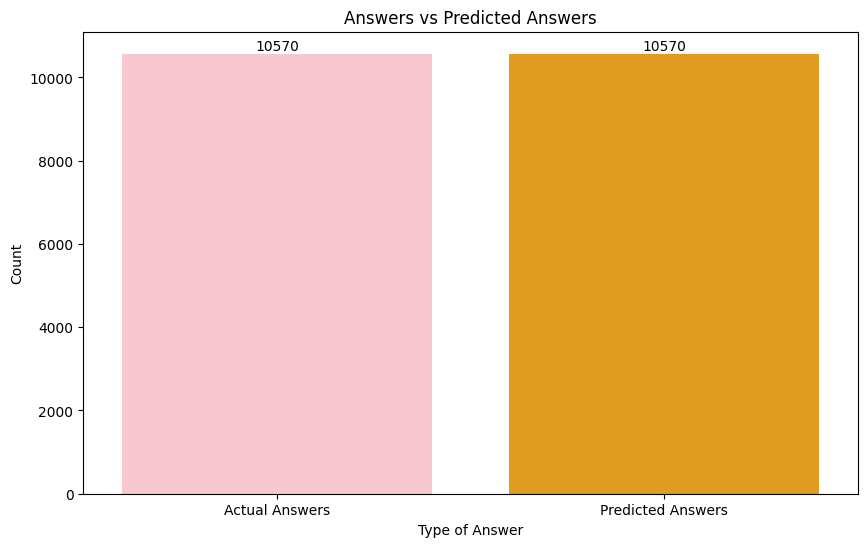

In [44]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    x=['Actual Answers', 'Predicted Answers'],
    y=[len(answers), len(predicted_answers)],
    palette=['pink', 'orange']
)

# Adding counts on top of each bar
for index, value in enumerate([len(answers), len(predicted_answers)]):
    bar_plot.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.title('Answers vs Predicted Answers')
plt.xlabel('Type of Answer')
plt.ylabel('Count')
plt.show()

## Plot-2: Distribution of Answer lengths

This plot depicts the frequency distribution of answer lengths of **Actual answers** from validation dataset as well as **Predicted answers**.

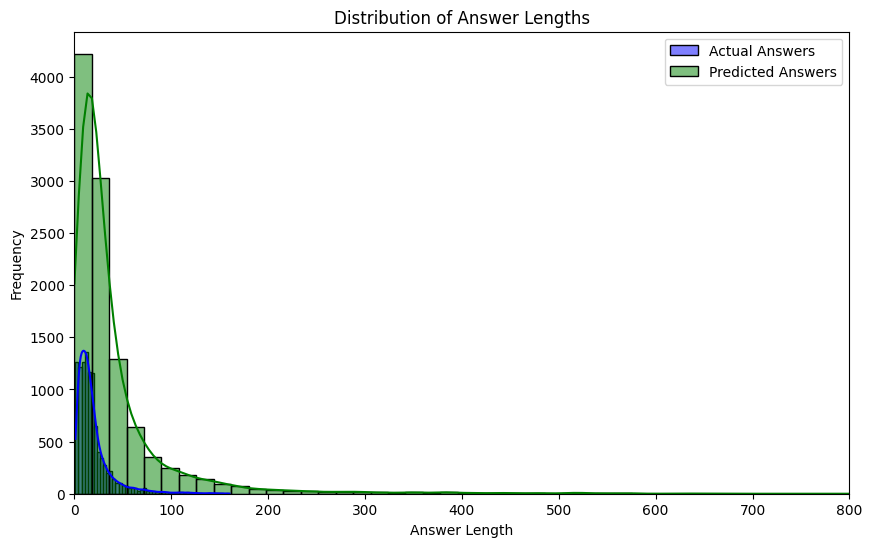

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot([len(answer) for answer in answers], label='Actual Answers', alpha=0.5, color='blue', bins=50, kde=True)
sns.histplot([len(answer) for answer in predicted_answers], label='Predicted Answers', alpha=0.5, color='green', bins=50, kde=True)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 800)
plt.show()

## Plot-3: Visualize the Evaluation Metrics post prediction

This barplot depicts the values of bleu score, rouge-1, rouge-2 and rougel scores.

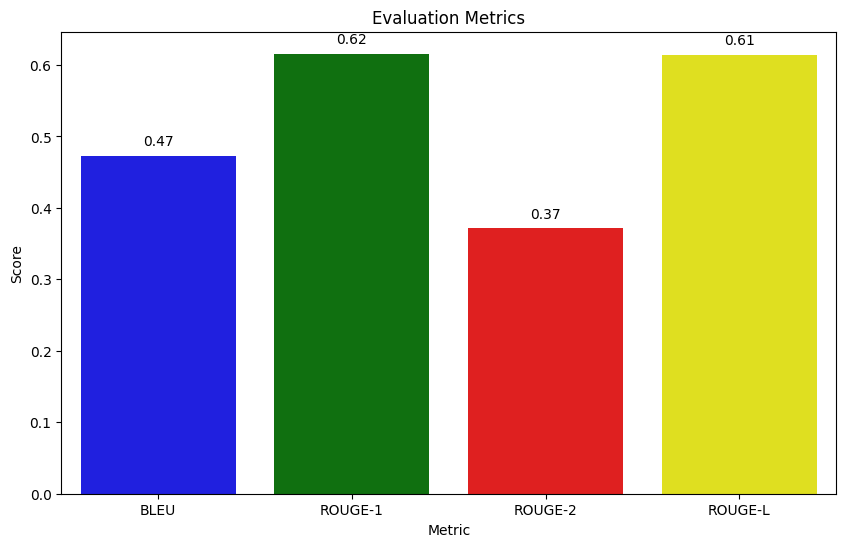

In [45]:
# Scores and labels
scores = [bleu, rouge1, rouge2, rougel]
labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Plot 3: BLEU score, ROUGE-1, ROUGE-2 and ROUGE-L score
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=labels, y=scores, palette=['blue', 'green', 'red', 'yellow'])

# Adding scores on top of each bar
for index, value in enumerate(scores):
    bar_plot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()

## Overall Observations from this approach:**

### Strengths and Tasks performed uniquely compared with GPT2-medium approach:

***Unlike GPT2-medium approach:***

Yes, unlike the GPT2-medium approach, we have achieved great results when we applied BERT's bert-based-uncased model. Look at the following points on what we had followed to acheive this.

- Here, we have uniquely followed by manually downloading the dataset, converting it to a dataframe and saving that file as well.
- We haven't directly applied tokenization on the text data captured from the dataset. Instead, we performed some data cleaning before that.
- We haven't used LoRA and PEFT techniques here. Instead, we used totally Pythonic approach to experiment how this model works by applying all the techniques using PyTorch library followed by the remaining ones.
- As the requirement is to build the chatbot, we have to generate the text based answers for the context and question passed in. Here, we have not only considered the text generation point of view, but also we are responsible to manage the context and handle variety of topics while generating the text.
- We made use of the `ans_start` and `ans_end` variables in the train dataset to capture the correct part of the answer.
- This model has not ran into issues/errors while executing in MacBooks. This model is environment agnostic.
- Though we don't have sufficient computational resources, we were able to achieve all the required results. Basically, we were able to validate all the 10570 rows of the validation dataset.
- This model might not have great text generation capabilities compared with GPT2-medium model. But, it understands the context very well and can almost exactly predict the answers as expected, although there are some issues with the edge case rows alone (example: the answer of a row would be `["Newton was limited by Denver's defense", 'Newton', 'Newton']`).
- Validation loss was of minor but not that minor than GPT2-medium architecture. Still if we compare it in context management and variety topics handling point of view, BERT model was so good.

- As I already mentioned in [this file](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_gpt2-medium/squad_lora_gpt2_medium_validation.ipynb), please be informed that usually such type of Question-Answering datasets does not qualify for a conversational chatbot that supports multi-turn conversations.

However, we had included the context-management as well as handling variety of topics. Let me explain them below.

    - ***Context Management***: We trained this model in such a way that if you just set the context once and ask multiple questions one after the other, it will definitely answer your questions based on that context. If at all you wish to change the context, just change it and ask the questions accordingly.
    - ***Handling Variety of topics***: Ofcourse we have handled this. Though we trained this using SQuAD dataset alone, even though you provide some random context from the internet and ask questions based on it, it will definitely answer your query.

For evidences, please take a look at the result files.

Links to the resultant files:

- [Dark Themed Chatbot UI Results of SQuAD Chatbot using BERT](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_bert-base-uncased/SQuAD_using_bert-base-uncased_chatbot_UI_Screenshots/SquAD_using_BERT_Dark_Themed_Chatbot_UI_Screenshots.pdf)

- [Light Themed Chatbot UI Results of SQuAD Chatbot using BERT](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_bert-base-uncased/SQuAD_using_bert-base-uncased_chatbot_UI_Screenshots/SquAD_using_BERT_White_Themed_Chatbot_UI_Screenshots.pdf)
    
- Let us take a look at the performance metrics scores of this model post predictions.

    - ***BLEU Score(0.47)***: Usually, BLEU score explains the similarity between the actual and predicted texts. If a BLEU  score value is  0.47, it means that there is a moderate (47%) similarity between the actual and predicted texts. It captures certain important phrases or sequences of words, though not exact.
    
    - ***ROUGE-1 (0.62)***: Assesses the similarity of individual words (unigrams) in the produced text and the reference. A score of 0.62 implies that approximately 62% of the individual words in the reference text are present in the generated output.

    - ***ROUGE-2 (0.37)***: Assesses the similarity of adjacent word pairs. A 0.37 score means approximately 37% of the bigrams from the reference are found in the generated output.

    - ***ROUGE-L (0.61)***: Takes into account the longest common subsequence (LCS) between the produced output and the reference. The score indicates that approximately 61% of the reference's content is accounted for by the longest matching sequences.

    Overall observation for ROUGE score is: the ROUGE scores indicate a moderate level of similarity between the generated responses and the reference answers, with better matching at the unigram level than at the bigram level.

    - Because, - As I already mentioned in [this file](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_gpt2-medium/squad_lora_gpt2_medium_validation.ipynb), there are few edge case anwers in the validation dataset such as `["Newton was limited by Denver's defense", 'Newton', 'Newton']`. Due to such reasons, along with using only the first 5 rows to predict, the ROUGE and BLEU scores were very low. But in general if you look at the above predicted results, this model has very well predicted the results.
    
    - Frequency distributions of both the actual and predicted answers' words are almost consistent from the histogram plotted above.

### Pain points noticed and the tasks that were not performed:

- Due to time constraints, we could not spend on handling the edge cases where multiple answers are available within the single question of the context in validation dataset (example: `["Newton was limited by Denver's defense", 'Newton', 'Newton']`).
- We might have lost the accuracy in terms of exactly matching the predicted answer with the actual answer. But still, I am very happy that the predicted answer is the correct one.
- Due to computational resource and time constraints, we performed only the following items in minimal amount:
    1. I could train only 3 epochs with sleepless nights with a very low level GPU that's embedded within my MacBook.
    2. We are unable to achieve multi-turn conversations feature because.

Overall, when we compare this approach with GPT2-medium approach, this has outperformed from its predictions, context management, handling variety of topics point of view.

**IMPORTANT NOTE:**

- Here, wherever I mention about ***not matching the predicted answer with actual answer*** means:
    - It could be appending additional response either to the prefix or suffix area of the predicted answer.
    - It could be because of predicted answer being displayed as `denver` and actual answer could be `Denver`.
    - It could be because of predicted answer being displayed as `denver` and actual answer could be `['Denver', 'Denver', 'Denver']`.

  But not from the obtained answer point of view.😊

### Future Improvement Suggestions:

- Try a hybrid mode of training. I mean - we can give a try to take 3 to 4 conversational dataset along with the current SQuAD one, train all of them to a single model, apply multi-turn conversational approaches and make it a complete chatbot. It should be similar to ChatGPT, perplexity.ai, blackbox.ai, Meta AI etc. etc.
- Try obtaining some high computational power so that the the training and validation can be perfectly done.

# Business use-cases of this Chatbot

Chatbots can be used in real-world at many places. Few use-cases would be:

- 24*7 customer support to handle customer queries and guide in resolving the issues.
- Automation of FAQs in any field.
- Users can check the status of their eCommerce orders and get notified about shipping updates.
- Users can get their banking informatione easily.
- Help students with basic educational information.
- Book online health consultations.
- Help astronauts and ground control by offering rapid access to mission information, schedules, and problem-solving guidelines. For example, they are able to access data on spacecraft systems or conduct simple calculations for navigation purposes.
- Utilize in streaming platforms to suggest songs, albums, or artists by considering user preferences and listening history. Additionally, they have the ability to recommend playlists tailored to certain emotions, tasks, or music styles.
- Communicate with robots in order to assist operators in managing or overseeing robotic systems. As an illustration, they are able to give status updates, manage motion, or carry out instructions in manufacturing industrial robots.